## Roomba: The first step is realizing that we have to think of a room not in terms of tiles, but in terms of nodes on a graph.

The problem has to be reframed in terms of graph traversal, specifically with nodes on an undirected graph. Obstacles in a room can be presented as missing links between nodes. 

Assumptions
- The room and all obstacles are considered rectilinear
- The robot has 360 vision
- The robot's job is to move through the scene so that it sees all parts of the room
- The robot does not know the room layout in advance



Let $L_A(S)$ be the length of the path traversed by the algorithm A to explore S. A does not know S in advance. $L_{*}(S)$ is the length of the path of the optimal algorithm. Essentially this is the number of edge traversals, and we want there to be as little as possible.

What if the robot needs to recharge?

## Base and DFS Strategy

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from random import choice, seed
import scipy.stats as sp
import seaborn as sns


In [176]:
class Roomba:
    def __init__(self, room_size = (5, 4), obstacles = 0):
        self.G = nx.grid_2d_graph(*room_size)
        nx.set_node_attributes(self.G, False, name = "visited")

        # create obstacles but keep graph strongly connected
        while obstacles > 0:
            copy = self.G.copy()
            copy.remove_node(choice(list(self.G.nodes)))
            
            if nx.number_connected_components(copy) == 1:
                self.G = copy
                obstacles -= 1
            else:
                continue
            
        self.pos = dict((n, n) for n in self.G.nodes()) # create square grid structure
        self.source = choice(list(self.G.nodes)) # random source node

        self.path = None
        self.algorithm = None
        
    def display(self, block = False):
        if self.path:
            # create old_dict from an enumeration of the path
            old_dict, new_dict = {v: k for v, k in enumerate([self.path[0][0]] + [i[1] for i in self.path] )}, {}

            # invert old_dict to get new_dict, which returns order in the path of given node
            for key, value in old_dict.items(): new_dict[value] = new_dict[value] + [key] if value in new_dict else [key]
            
            # format new_dict into readable format
            for key, value in new_dict.items(): new_dict[key] = value[0] if len(value) == 1 else tuple(value)

            nx.draw(self.G, self.pos)
            nx.draw(self.G, self.pos, edgelist = self.path, edge_color = 'r', width = 6, labels = new_dict)
            plt.title(f'{self.algorithm} Algorithm Finished in {len(self.path)} Units')
#             plt.show(block = block)
            
        else:
            nx.draw(self.G, self.pos, labels = {self.source: "Source"})
            plt.title('Algorithm Not Yet Run')
#             plt.show(block = block)

        
    def random(self):
        nx.set_node_attributes(self.G, False, name = "visited")
        self.G.node[self.source]['visited'] = True
        current_node = self.source
        path = list()

        # while all nodes not visited
        while not (all(x for x in nx.get_node_attributes(self.G, "visited").values())):

            # get neighbors
            neighbors = [i for i in self.G[current_node]]

            next_cell = choice(neighbors) # choose next neighbor
            self.G.node[next_cell]['visited'] = True # move to that neighbor
            
            path.append((current_node, next_cell)) # add coordinate to part of search path
            current_node = next_cell

        self.path = path
        self.algorithm = "Random"
        return self.path
        
    def dfs(self, choice = "first"):
        nx.set_node_attributes(self.G, False, name = "visited")
        self.G.node[self.source]['visited'] = True
        current_node = self.source
        visited_cells, path = list(), list()
        
        # while all nodes not visited
        while not (all(x for x in nx.get_node_attributes(self.G, "visited").values())):
            
            # get unvisited neighbors
            neighbors = [i for i in self.G[current_node] if self.G.node[i]['visited'] == False]
            
            # if there are unvisted neighbor cells
            if neighbors:
                visited_cells.append(current_nodeent_node) # add current cell to stack

                if choice == "first":
                    next_cell = neighbors[0]
                elif choice == "last":
                    next_cell = neighbors[-1]
                else:
                    next_cell = choice(neighbors)
                
                self.G.node[next_cell]['visited'] = True # move to that neighbor
            
            elif len(visited_cells) > 0: # if no unvisited neighbors, backtrack
                next_cell = visited_cells.pop()
                
            path.append((current_node, next_cell)) # add coordinate to part of search path
            current_node = next_cell
        
        self.path = path
        self.algorithm = "DFS"
        return self.path
    
    def circular(self):
        nx.set_node_attributes(self.G, False, name = "visited")
        self.G.node[self.source]['visited'] = True
        current_node = self.source
        visited_cells, path = list(), list()
        direction = np.array([[-1,0], [0,-1], [1,0], [0,1] ]) # W S E N
        prev_dir = 0 # keeps track of the last direction it went in
        
        # while all nodes not visited
        while not (all(x for x in nx.get_node_attributes(self.G, "visited").values())):
            
            # get unvisited neighbors
            neighbors = [i for i in self.G[current_node] if self.G.node[i]['visited'] == False]

            # if there are unvisted neighbor cells
            if neighbors:
                visited_cells.append(current_node) # add current cell to stack
                
                # The list for the next direction involves rolling and inverting
                next_list = np.roll(direction, shift = -prev_dir, axis = 0)
                next_list[[0,1,2,3]] = next_list[[1,0,3,2]]

                for j, i in enumerate(next_list):
                    if tuple(i + current_node) in neighbors: 

                        prev_dir = np.where(np.all(direction == i, axis=1))[0][0]
                        next_cell = tuple(i + current_node)
                        break
                
                self.G.node[next_cell]['visited'] = True # move to that neighbor
            
            elif len(visited_cells) > 0: # if no unvisited neighbors, backtrack
                next_cell = visited_cells.pop()
                
            path.append((current_node, next_cell)) # add coordinate to part of search path
            current_node = next_cell
        
        self.path = path
        self.algorithm = "Circular"
        return self.path

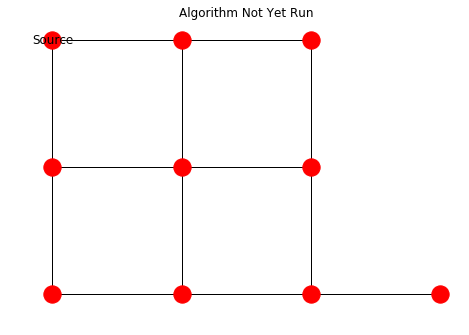

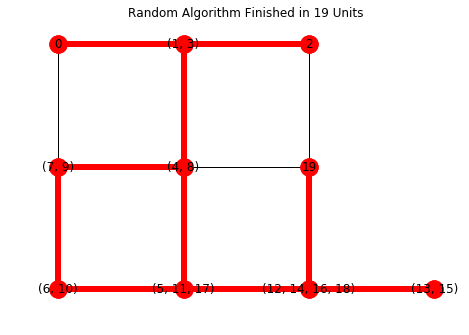

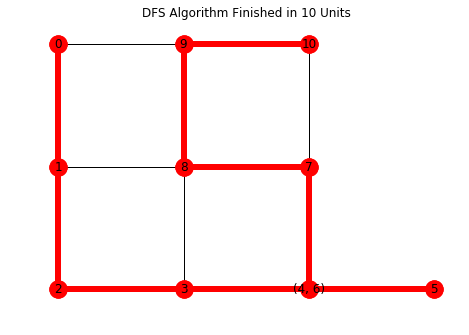

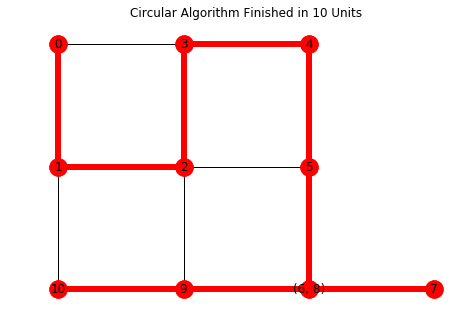

In [179]:
# seed(12) # very funny
# seed(30) # very bad
seed(20) # typical behavior


test = Roomba(room_size = (4,3), obstacles = 2)
test.display()
plt.savefig("Base.png", bbox_inches='tight')
plt.show()


test.random()
test.display()
plt.savefig("Random.png", bbox_inches='tight')
plt.show()


test.dfs()
test.display()
plt.savefig("DFS.png", bbox_inches='tight')
plt.show()


test.circular()
test.display()
plt.savefig("Circular.png", bbox_inches='tight')
plt.show()




In [ ]:
2 + 2

## How do the algorithms scale with Room Size?

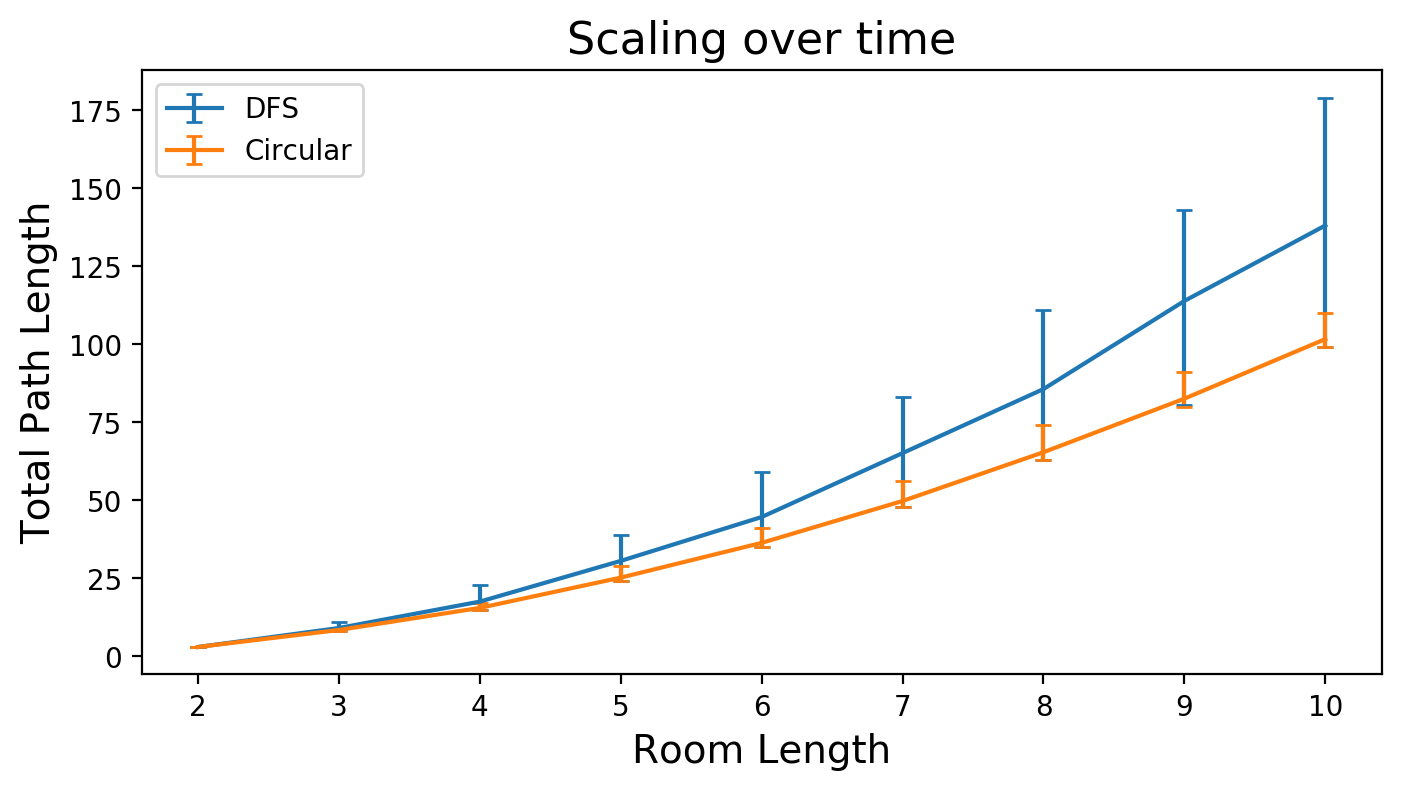

In [657]:
iterations = 100
min_room, max_room = 1, 10
times_dfs, times_circular, times_difference = [], [], []

for i in range(min_room + 1, max_room + 1):
    times_dfs_small, times_circular_small, times_difference_small = [], [], []

    for _ in range(iterations):
        test = Roomba((i,i))
        dfs_time, circular_time = len(test.dfs()), len(test.circular())
        
        times_dfs_small.append(dfs_time)
        times_circular_small.append(circular_time)
        times_difference_small.append(dfs_time - circular_time)
        
    times_dfs.append(times_dfs_small)
    times_circular.append(times_circular_small)
    times_difference.append(times_difference_small) 
        

plt.figure(figsize = (8, 4), dpi = 200)

plt.errorbar(x = np.arange(min_room + 1, max_room + 1),
             y = np.mean(times_dfs, axis = 1), capsize = 3,
             yerr = [np.mean(times_dfs, axis = 1) - np.percentile(times_dfs, 2.5, axis = 1),
                     np.percentile(times_dfs, 97.5, axis = 1) - np.mean(times_dfs, axis = 1)],
            label = "DFS")

plt.errorbar(x = np.arange(min_room + 1, max_room + 1),
             y = np.mean(times_circular, axis = 1), capsize = 3,
             yerr = [np.mean(times_circular, axis = 1) - np.percentile(times_circular, 2.5, axis = 1),
                     np.percentile(times_circular, 97.5, axis = 1) - np.mean(times_circular, axis = 1)],
            label = "Circular")


plt.ylabel("Total Path Length", fontsize = 14)
plt.xlabel("Room Length", fontsize = 14)
plt.title("Scaling over time", fontsize = 16)
plt.legend()
plt.savefig("scalingcomparison.png", bbox_inches='tight')
plt.show()

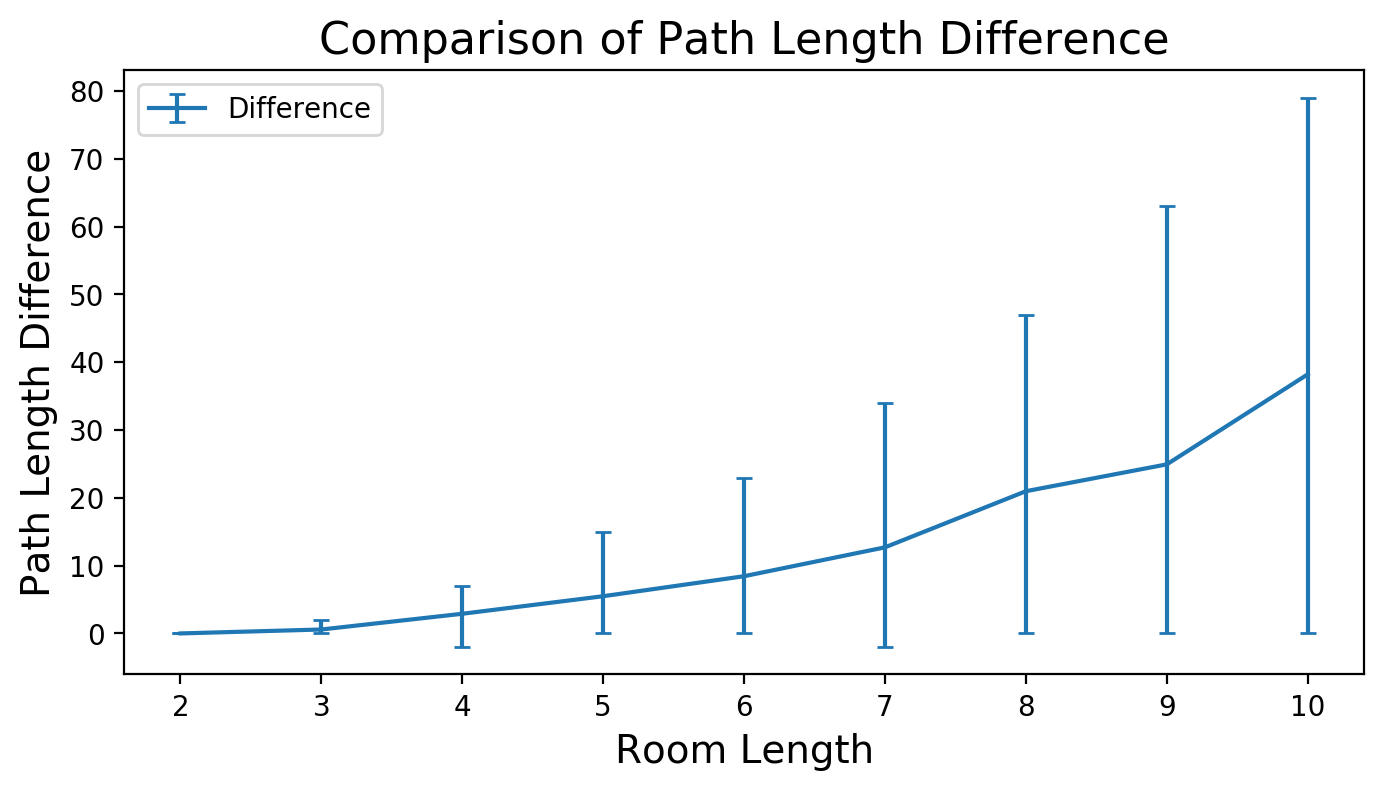

In [656]:
plt.figure(figsize = (8,4), dpi = 200)

plt.errorbar(x = np.arange(min_room + 1, max_room + 1),
             y = np.mean(times_difference, axis = 1), capsize = 3,
             yerr = [np.mean(times_difference, axis = 1) - np.percentile(times_difference, 2.5, axis = 1),
                     np.percentile(times_difference, 97.5, axis = 1) - np.mean(times_difference, axis = 1)],
            label = "Difference")



plt.ylabel("Path Length Difference", fontsize = 14)
plt.xlabel("Room Length", fontsize = 14)
plt.title("Comparison of Path Length Difference", fontsize = 16)
plt.legend()
plt.savefig("differencecomparison.png", bbox_inches='tight')
plt.show()

## When is DFS Faster than Circular?
In total, there are 8 spiralling patterns, and there are 2 clockwise roomba patterns. 

The cases in which the DFS beats tbe circular algorithm are in very rare cases. 

- 4 x 4, there is 1 (faster by 2)
- 5 x 5, there is 1 (faster by 2)
- 6 x 6, there is 1 (faster by 4)
- 7 x 7, there is 1 (faster by 2)



### In Empty Rooms

In [236]:
circular_better, dfs_better, equal = [], [], []

for dim in range(2, 11):
    paths_dfs_better, paths_equal = [], []

    for j in range(1000):
        rooms = Roomba(room_size = (dim,dim))
        path_circular = rooms.circular()
        path_dfs = rooms.dfs("first")

        if len(path_dfs) < len(path_circular) and rooms.path not in paths_dfs_better:
            paths_dfs_better.append(rooms.path)

        elif len(path_dfs) == len(path_circular) and rooms.path not in paths_equal:
            paths_equal.append(rooms.path)

    print(f"Room size: {dim}x{dim}", 
          f"dfs better: {len(paths_dfs_better)}",
          f"circular better: {dim**2 - len(paths_equal) - len(paths_dfs_better)}",
          f"equal: {len(paths_equal)}, total: {dim**2}")
    circular_better.append((dim**2 - len(paths_equal) - len(paths_dfs_better))/dim**2)
    dfs_better.append(len(paths_dfs_better)/dim**2)
    equal.append(len(paths_equal)/dim**2)
    


Room size: 2x2 dfs better: 0 circular better: 0 equal: 4, total: 4
Room size: 3x3 dfs better: 0 circular better: 3 equal: 6, total: 9
Room size: 4x4 dfs better: 1 circular better: 9 equal: 6, total: 16
Room size: 5x5 dfs better: 1 circular better: 16 equal: 8, total: 25
Room size: 6x6 dfs better: 1 circular better: 29 equal: 6, total: 36
Room size: 7x7 dfs better: 1 circular better: 40 equal: 8, total: 49
Room size: 8x8 dfs better: 2 circular better: 56 equal: 6, total: 64
Room size: 9x9 dfs better: 1 circular better: 72 equal: 8, total: 81
Room size: 10x10 dfs better: 2 circular better: 91 equal: 7, total: 100


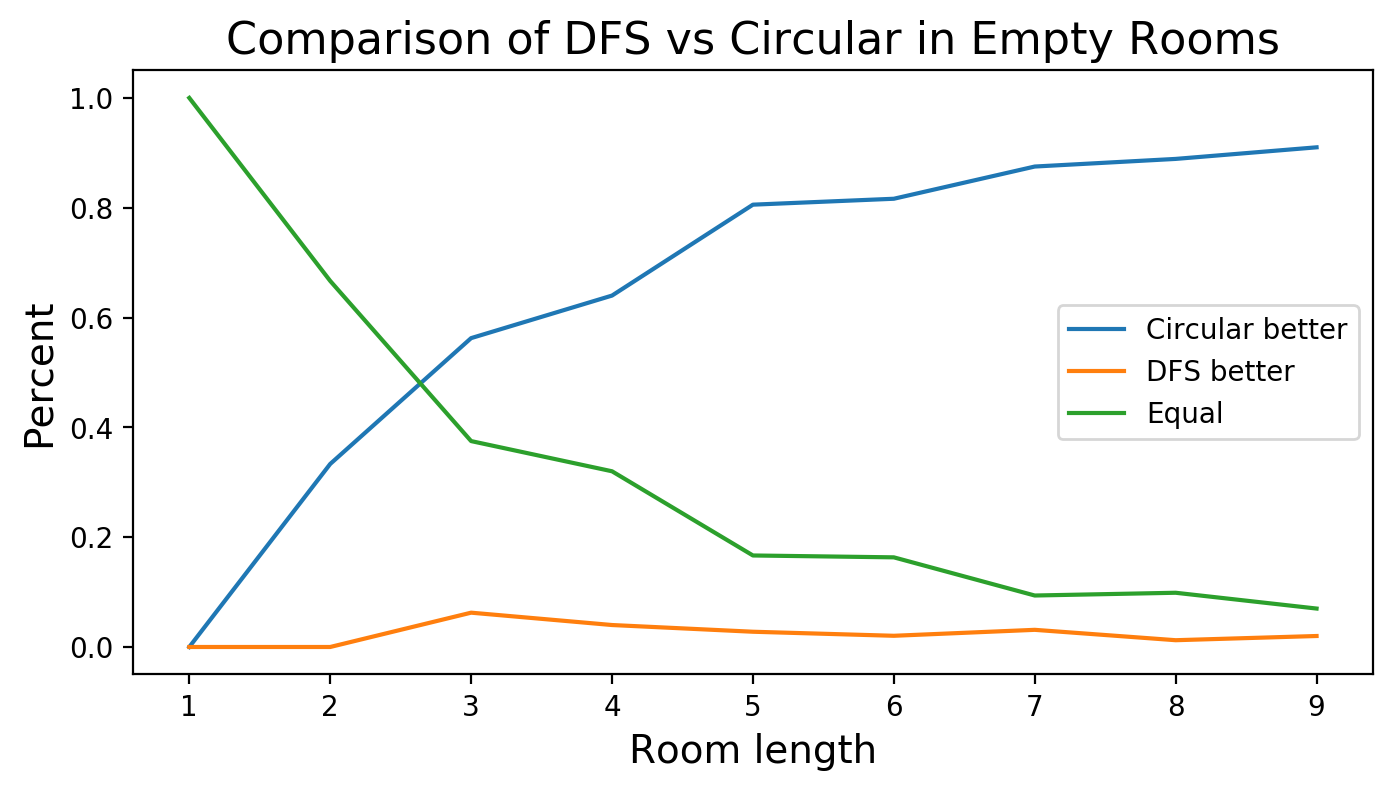

In [653]:
plt.figure(figsize=(8,4), dpi = 200)
plt.plot(range(1,10), circular_better, label = "Circular better")
plt.plot(range(1,10), dfs_better, label = "DFS better")
plt.plot(range(1,10), equal, label = "Equal")
plt.xlabel("Room length", fontsize = 14)
plt.ylabel("Percent", fontsize = 14)
plt.title("Comparison of DFS vs Circular in Empty Rooms", fontsize = 16)
plt.legend()
plt.savefig("Circularvsdfsempty.png", bbox_inches='tight')
plt.show()

## In rooms with Obstacles

In [ ]:
circular_better, dfs_better, equal = [], [], []

for dim in range(2, 11):
    paths_dfs_better, paths_equal = [], []

    for j in range(1000):
        rooms = Roomba(room_size = (dim,dim))
        path_circular = rooms.circular()
        path_dfs = rooms.dfs("first")

        if len(path_dfs) < len(path_circular) and rooms.path not in paths_dfs_better:
            paths_dfs_better.append(rooms.path)

        elif len(path_dfs) == len(path_circular) and rooms.path not in paths_equal:
            paths_equal.append(rooms.path)

    print(f"Room size: {dim}x{dim}", 
          f"dfs better: {len(paths_dfs_better)}",
          f"circular better: {dim**2 - len(paths_equal) - len(paths_dfs_better)}",
          f"equal: {len(paths_equal)}, total: {dim**2}")
    circular_better.append((dim**2 - len(paths_equal) - len(paths_dfs_better))/dim**2)
    dfs_better.append(len(paths_dfs_better)/dim**2)
    equal.append(len(paths_equal)/dim**2)
    



break


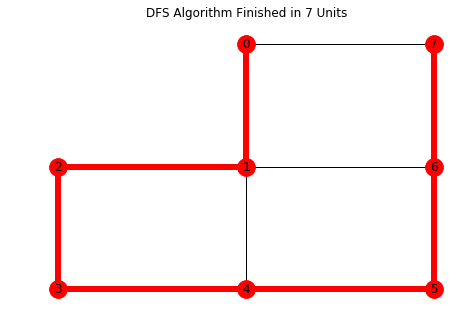

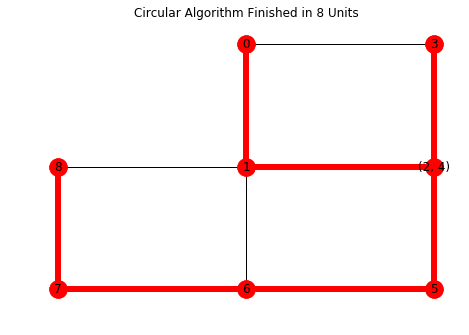

break


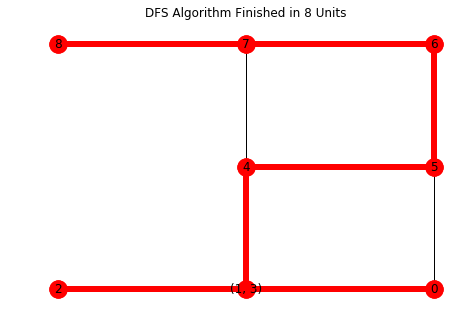

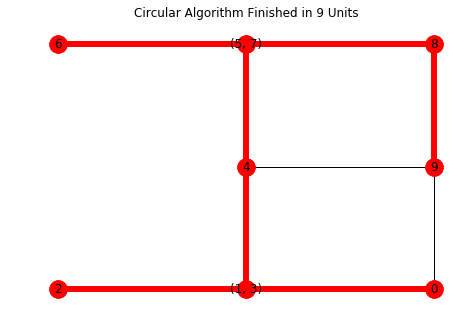

break


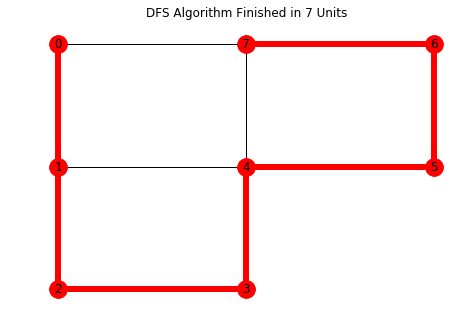

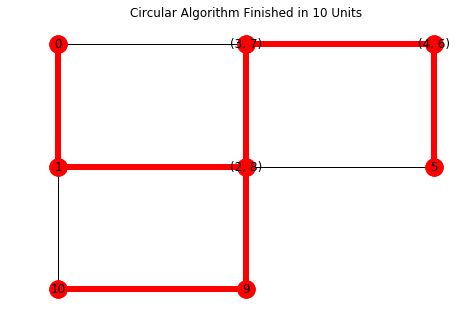

break


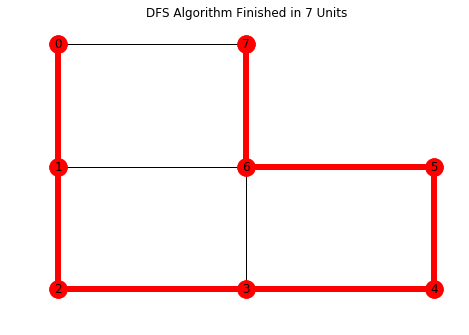

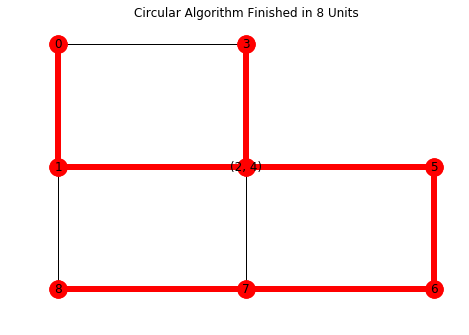

break


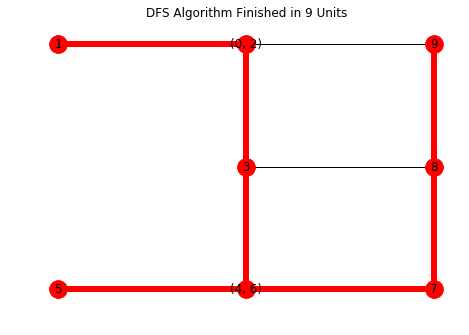

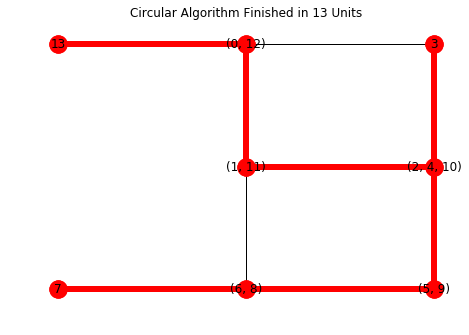

break


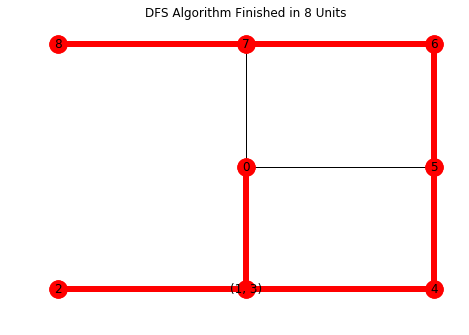

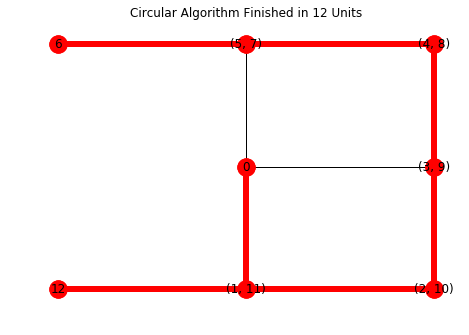

break


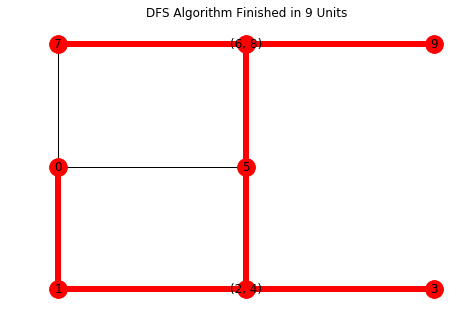

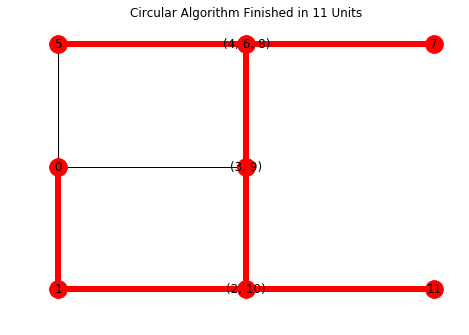

break


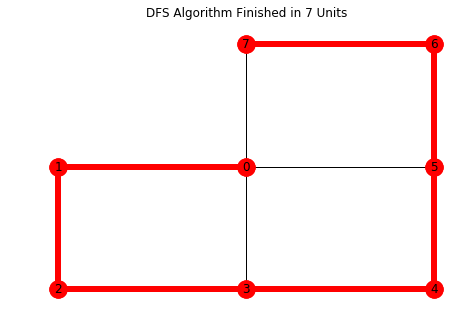

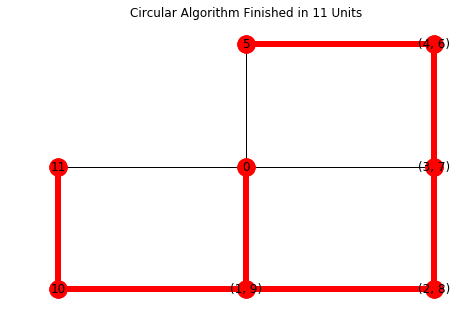

break


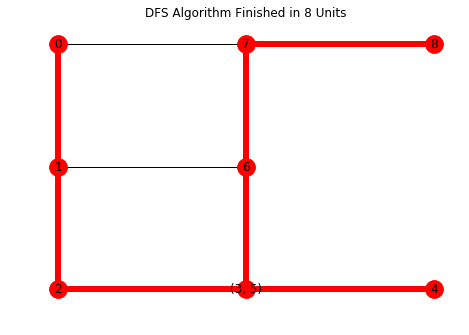

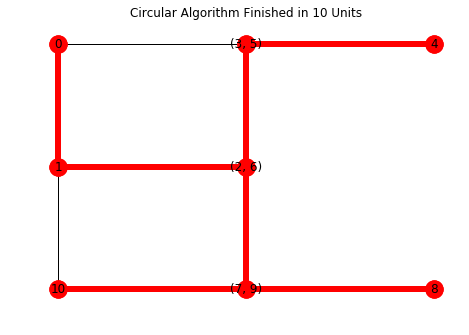

break


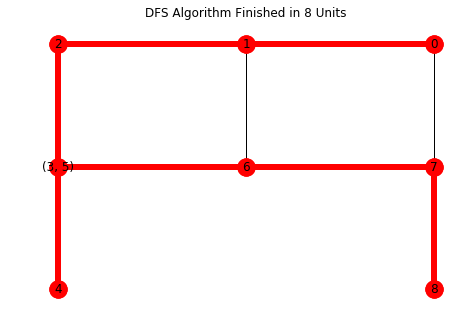

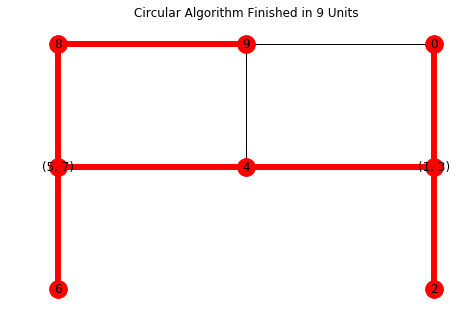

break


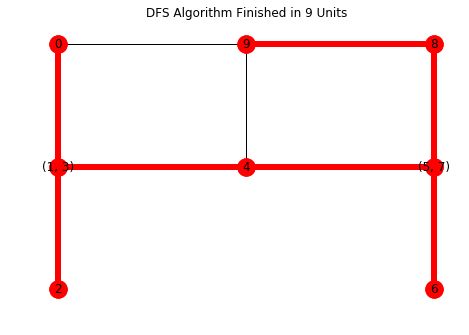

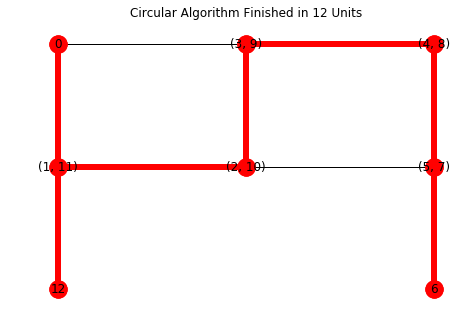

break


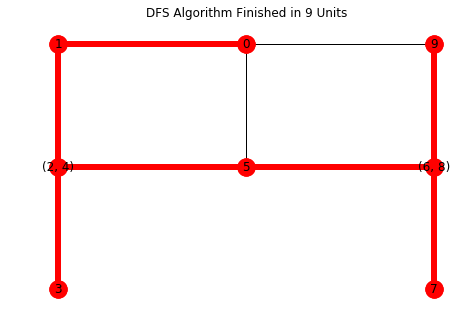

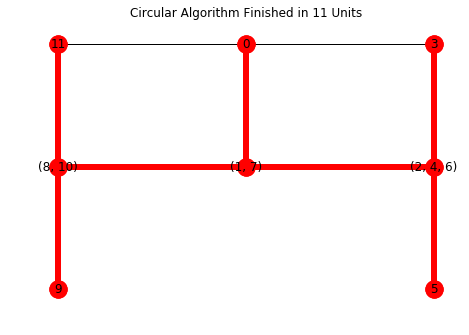

break


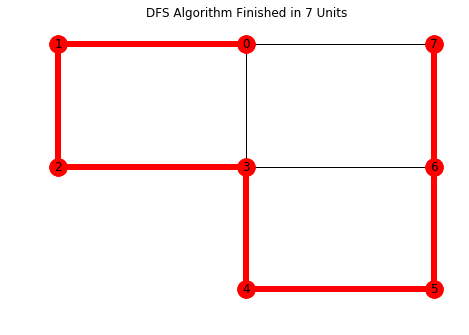

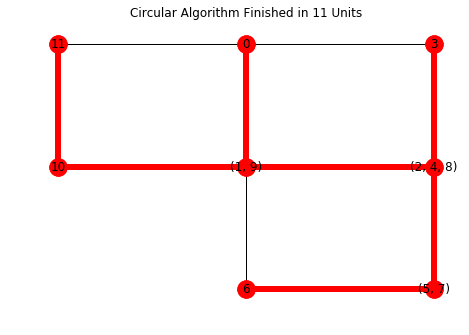

break


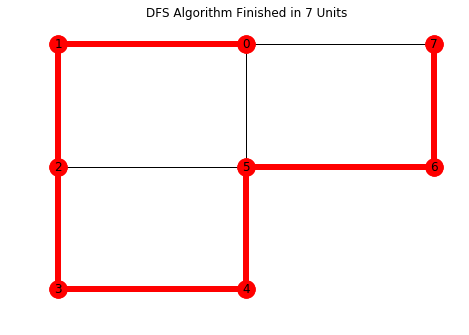

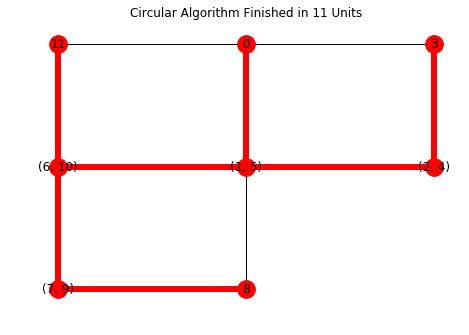

break


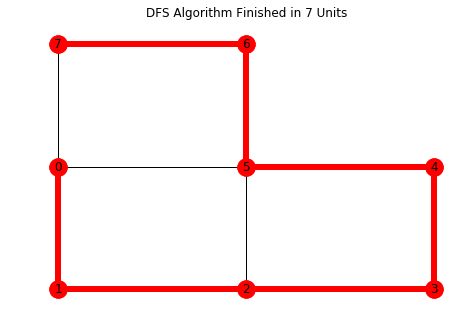

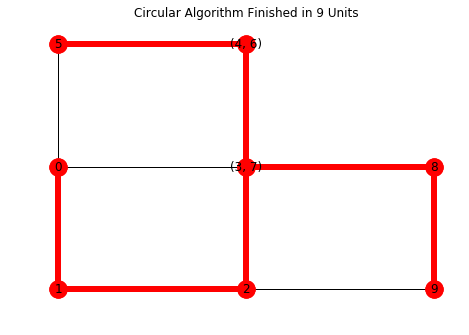

break


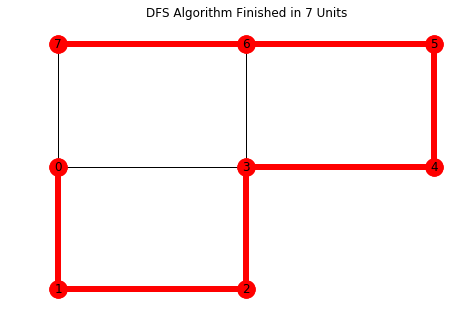

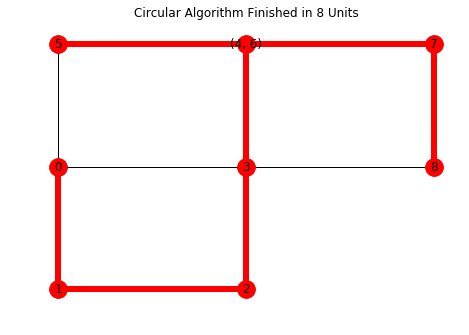

In [188]:
paths = []
for j in range(1000):
    rooms = Roomba(room_size = (3,3), obstacles = 1)
    path_circular = rooms.circular()
    path_dfs = rooms.dfs("first")
    
    if len(path_dfs) < len(path_circular) and rooms.path not in paths:
        print("break")
        paths.append(rooms.path)
        rooms.display(True)
#         plt.savefig("obs_dfs_faster.png", bbox_inches='tight')
        plt.show()
        
        rooms.circular()
        rooms.display(True)
#         plt.savefig("obs_circular_slower.png", bbox_inches='tight')
        plt.show()

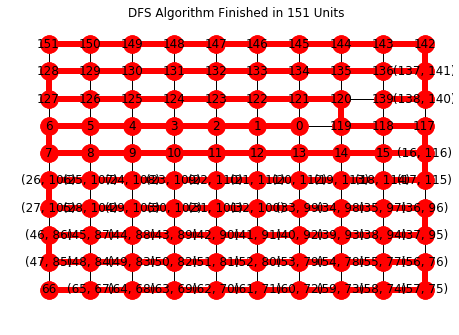

In [651]:
seed(17)
test = Roomba((10,10), obstacles = 0)
test.dfs()
test.display()
plt.savefig('largedfs.png')
plt.show()

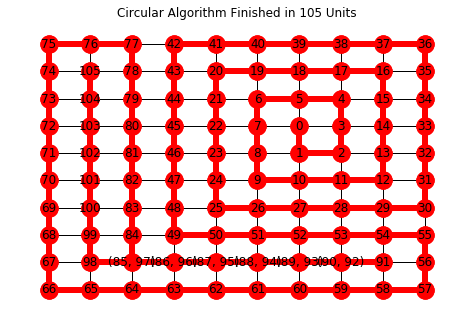

In [650]:
seed(17)
test = Roomba((10,10), obstacles = 0)
test.circular()
test.display()
plt.savefig('largecircular.png')
plt.show()

## What if there are rectilinear obstacles? (this takes 15-20 minutes to run)

In [778]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from math import floor

iterations = 500
min_room, max_room = 1, 10
# times_dfs, times_circular = np.array([]), np.array([])

# times_dfs = np.zeros(shape = (max_room + 1, max_room + 1, iterations)) # length, obstacles, iterations

times_dfs, times_circular = [], []

for room_length in range(min_room + 1, max_room + 1):
    print(room_length)
    for obstacles in range(floor((room_length**2)/3)):
#     for obstacles in range(room_length):
        for i in range(iterations):
            test = Roomba((room_length, room_length), obstacles)
            times_dfs.append([room_length, obstacles, len(test.dfs())])
            times_circular.append([room_length, obstacles, len(test.circular())])
            

2
3
4
5
6
7
8
9
10


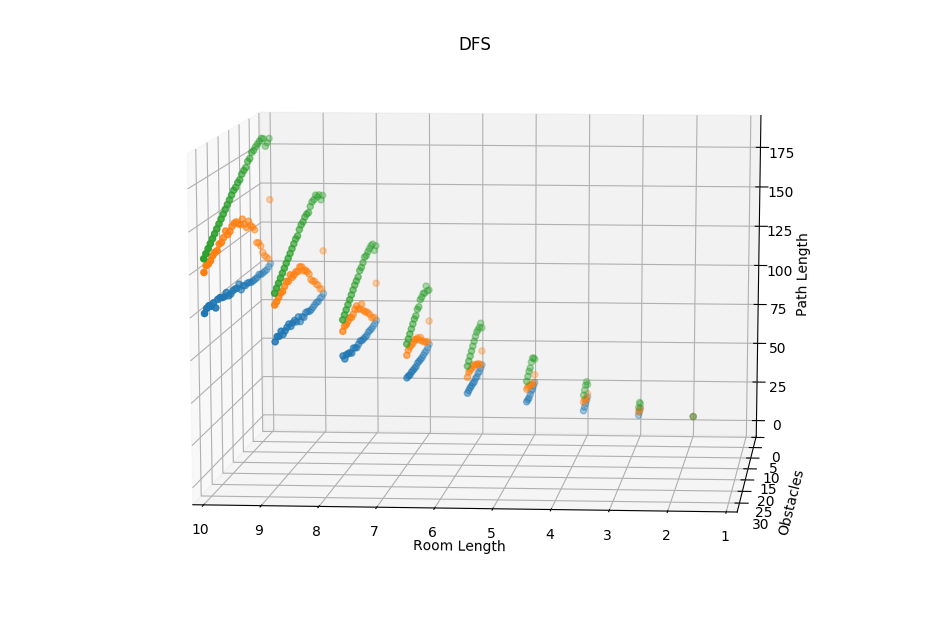

In [732]:
i = 0

dfs_mean = np.mean(np.array(times_dfs)[:,2].reshape(-1,500), axis = 1)
dfs_low, dfs_med, dfs_high = np.percentile(np.array(times_dfs)[:,2].reshape(-1,500), [2.5, 50, 97.5], axis = 1)

mean_dfs, low_dfs, high_dfs, med_dfs = [], [],[], []

for room_length in range(min_room + 1, max_room + 1):
#     for obstacles in range(room_length):
    for obstacles in range(floor((room_length**2)/3)):
        mean_dfs.append([room_length, obstacles, dfs_mean[i]])
        med_dfs.append([room_length, obstacles, dfs_med[i]])
        low_dfs.append([room_length, obstacles, dfs_low[i]])
        high_dfs.append([room_length, obstacles, dfs_high[i]])
        i += 1
        

fig = plt.figure(figsize = (12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10, azim=95)
ax.set_xlabel('Room Length', linespacing=3.4)
ax.set_ylabel('Obstacles', linespacing=3.4)
ax.set_zlabel('Path Length', linespacing=3.4)
ax.set_xlim3d(min_room, max_room)
ax.set_ylim3d(0, floor((room_length**2)/3)) # obstacles max room_length

for i in [low_dfs, med_dfs, high_dfs]:
        ax.scatter(np.array(i)[:,0], np.array(i)[:,1], np.array(i)[:,2], label = str(i))

plt.title('DFS')
plt.savefig("newdfsobstacles.png", bbox_inches='tight')
plt.show()

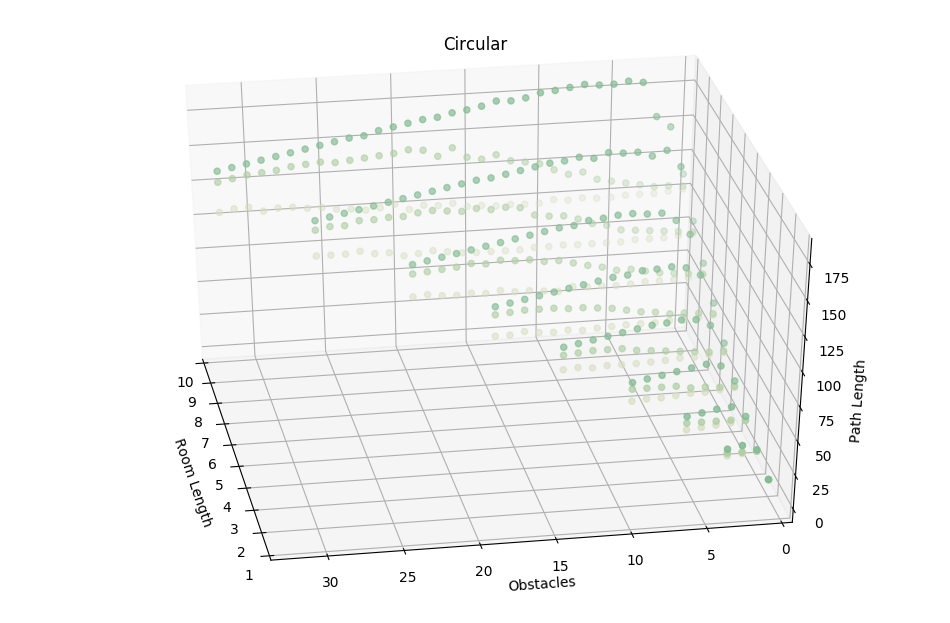

In [847]:
i = 0

circular_mean = np.mean(np.array(times_circular)[:,2].reshape(-1,500), axis = 1)
circular_low, circular_med, circular_high = np.percentile(np.array(times_circular)[:,2].reshape(-1,500), [2.5, 50, 97.5], axis = 1)

mean_circ, low_circ, high_circ, med_circ = [], [], [], []

for room_length in range(min_room + 1, max_room + 1):
#     for obstacles in range(room_length):
    for obstacles in range(floor((room_length**2)/3)):
        
        mean_circ.append([room_length, obstacles, circular_mean[i]])
        med_circ.append([room_length, obstacles, circular_med[i]])
        low_circ.append([room_length, obstacles, circular_low[i]])
        high_circ.append([room_length, obstacles, circular_high[i]])
        i += 1
        
        
fig = plt.figure(figsize = (12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=10, azim=95)
ax.view_init(elev=35, azim=-190)
ax.set_xlabel('Room Length', linespacing=3.4)
ax.set_ylabel('Obstacles', linespacing=3.4)
ax.set_zlabel('Path Length', linespacing=3.4)
ax.set_xlim3d(min_room, max_room)
ax.set_ylim3d(0, floor((room_length**2)/3)) # obstacles max room_length

for i in [low_circ, med_circ, high_circ]:
        ax.scatter(np.array(i)[:,0], np.array(i)[:,1], np.array(i)[:,2], label = str(i))
        

plt.title('Circular')
# plt.savefig("newcircularobstacles.png", bbox_inches='tight')
plt.show()

## Normality Test

In [781]:
print(sp.normaltest(np.array(times_dfs)[:,2][-500:])) # not normally distributed, use mann-whitney U instead.

A = np.array(times_dfs)[:,0] == 10
B = np.array(times_dfs)[:,1] == 2

# np.array(times_circular)[:,2][A & B]
# np.array(times_dfs)[:, 2][A & B]

sp.mannwhitneyu(np.array(times_circular)[:,2][A & B],  np.array(times_dfs)[:, 2][A & B], alternative = "less")


MannwhitneyuResult(statistic=102470.5, pvalue=3.860461162904612e-07)

In [765]:
greater, less = [], []

for room_length in range(min_room + 2, max_room + 1):
#     for obstacles in range(room_length):
    for obstacles in range(floor((room_length**2)/3)):
        
        A = np.array(times_circular)[:,0] == room_length
        B = np.array(times_circular)[:,1] == obstacles
        
        greater.append([room_length, obstacles, 
                        sp.mannwhitneyu(np.array(times_dfs)[:, 2][A & B], 
                                        np.array(times_circular)[:,2][A & B], alternative = "greater")[1]])
        less.append([room_length, obstacles,
                     sp.mannwhitneyu(np.array(times_dfs)[:, 2][A & B], 
                                     np.array(times_circular)[:,2][A & B], alternative = "less")[1]])

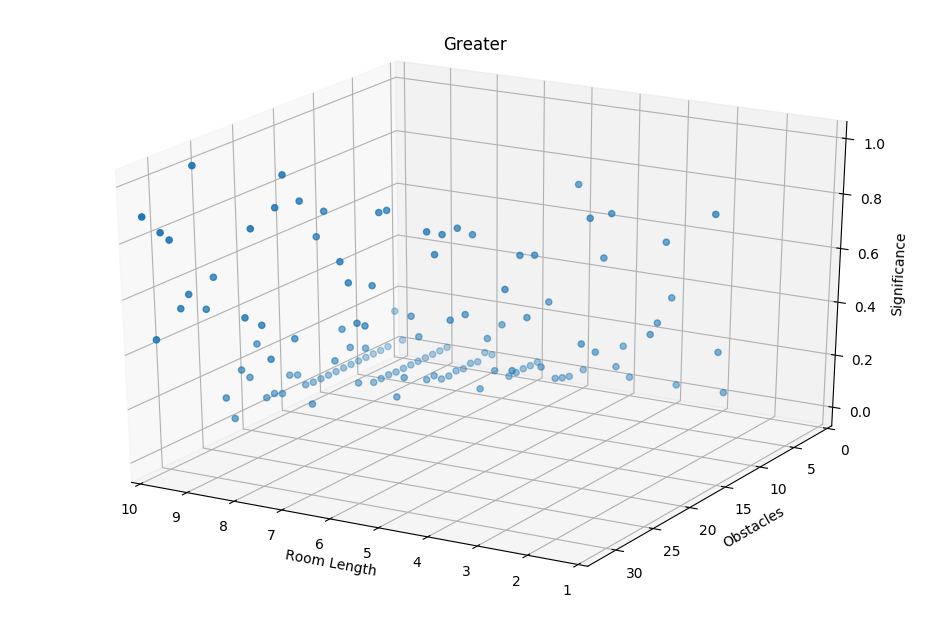

In [782]:
fig = plt.figure(figsize = (12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=25, azim=120)
ax.set_xlabel('Room Length', linespacing=3.4)
ax.set_ylabel('Obstacles', linespacing=3.4)
ax.set_zlabel('Significance', linespacing=3.4)
ax.set_xlim3d(min_room, max_room)
ax.set_ylim3d(0, floor((room_length**2)/3)) # obstacles max room_length

ax.scatter(np.array(greater)[:,0], np.array(greater)[:,1], np.array(greater)[:,2])
        

plt.title('Greater')
# plt.savefig("newcircularobstacles.png", bbox_inches='tight')
plt.show()

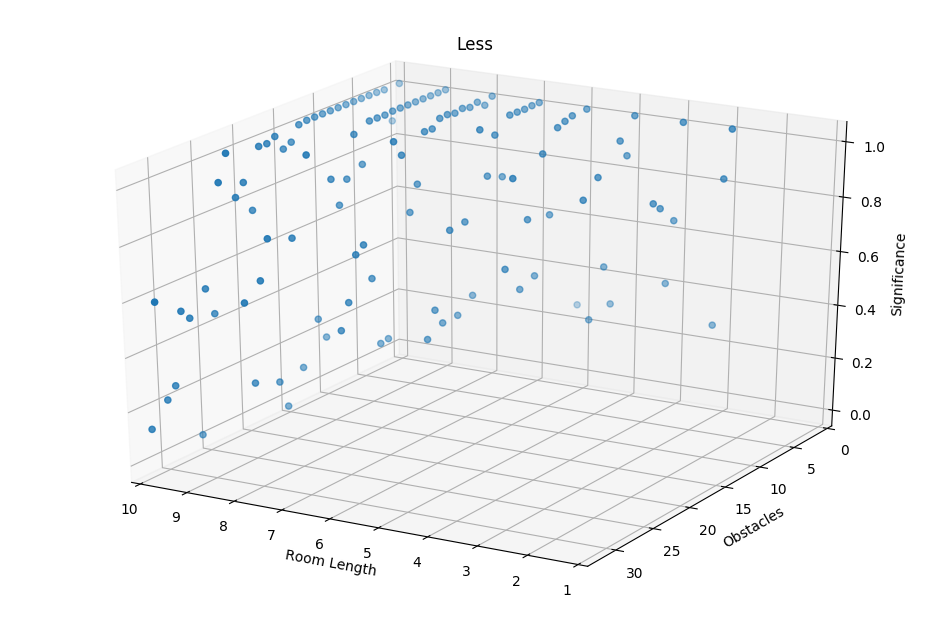

In [767]:
fig = plt.figure(figsize = (12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=25, azim=120)
ax.set_xlabel('Room Length', linespacing=3.4)
ax.set_ylabel('Obstacles', linespacing=3.4)
ax.set_zlabel('Significance', linespacing=3.4)
ax.set_xlim3d(min_room, max_room)
ax.set_ylim3d(0, floor((room_length**2)/3)) # obstacles max room_length

ax.scatter(np.array(less)[:,0], np.array(less)[:,1], np.array(less)[:,2], label = str(less))
# ax.scatter(np.array(greater)[:,0], np.array(greater)[:,1], np.array(greater)[:,2], label = str(greater))
plt.title('Less')
# plt.savefig("less.png", bbox_inches='tight')
plt.show()

## DFS (with obstacles)  Histogram

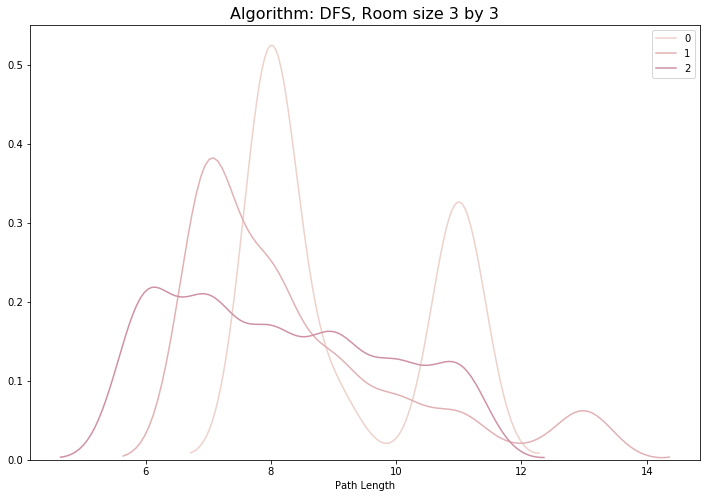

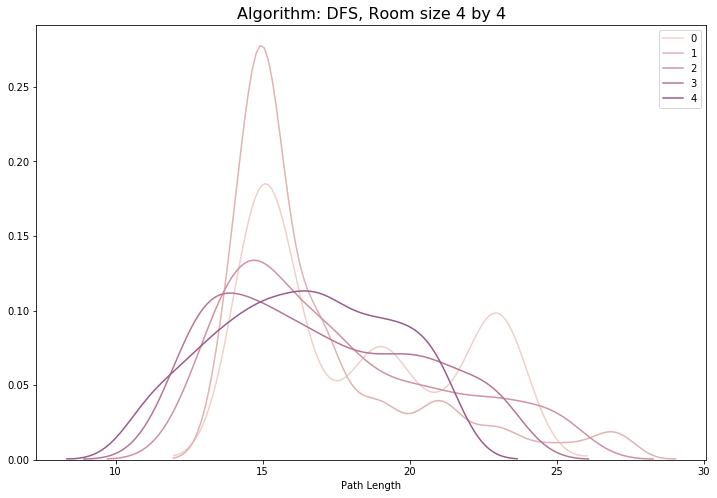

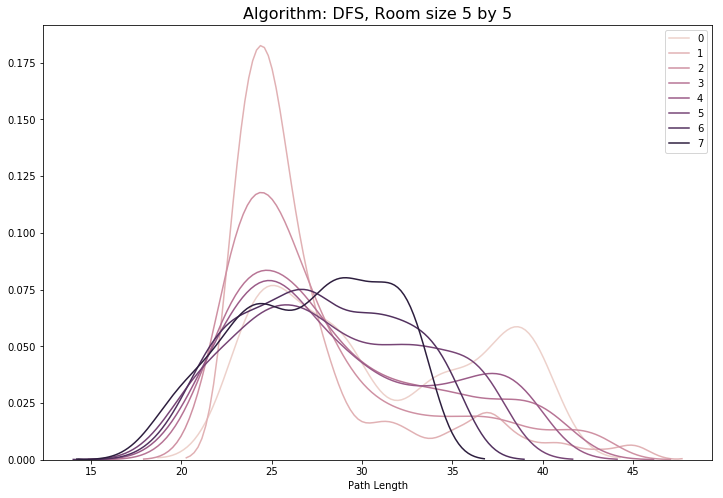

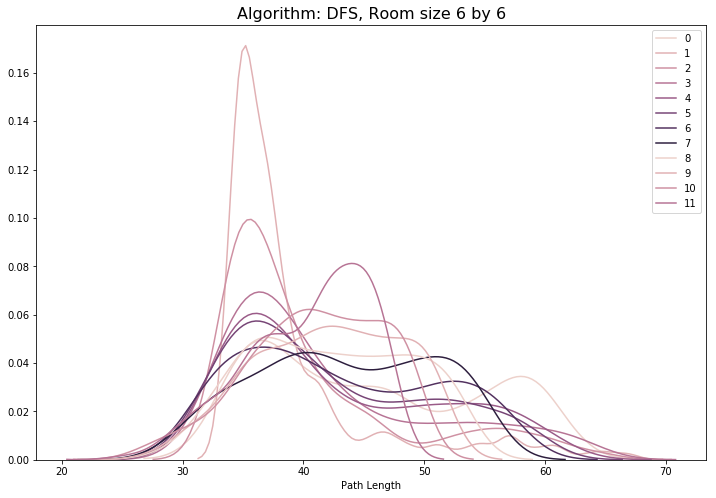

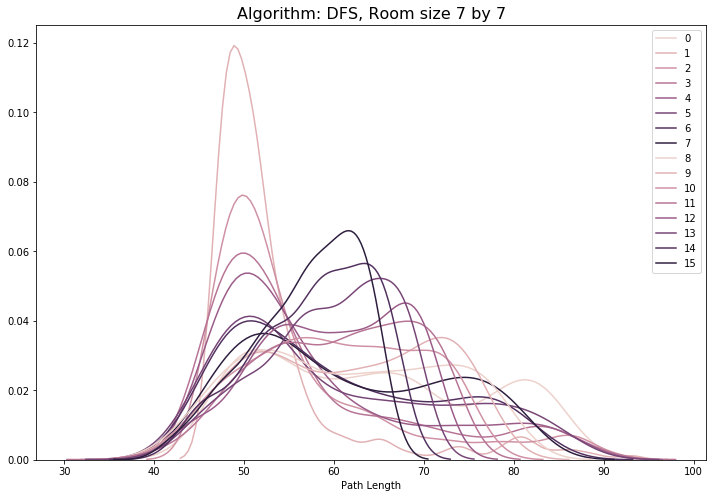

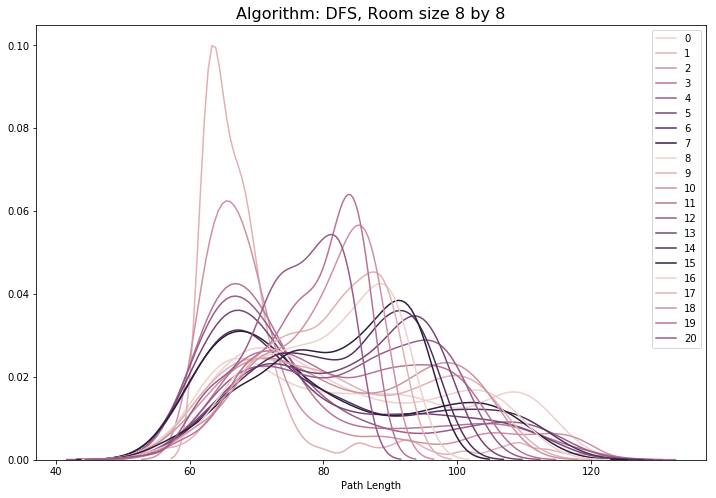

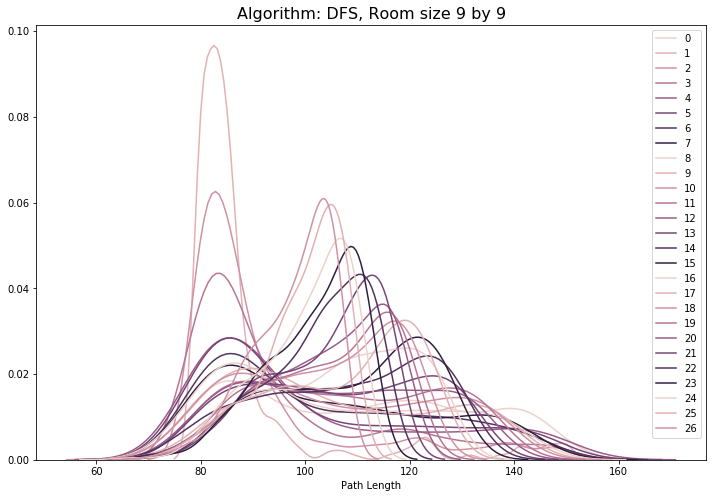

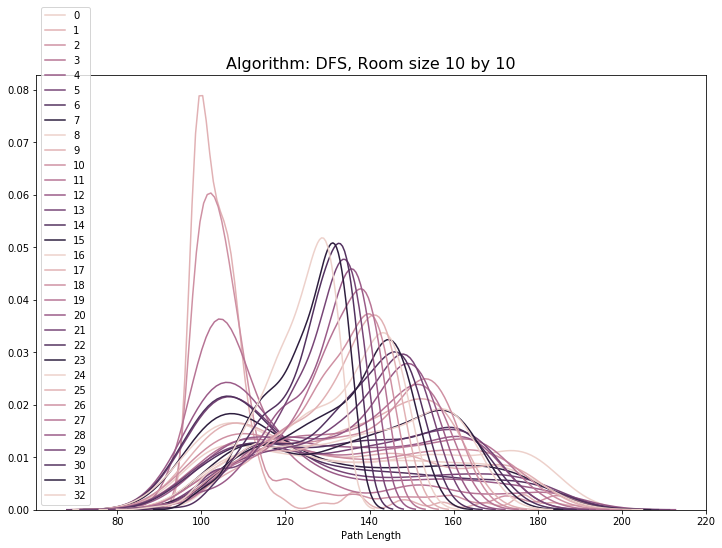

In [809]:
sns.set_palette(sns.cubehelix_palette(8))

for room_length in range(min_room + 2, max_room + 1):
#     for obstacles in range(room_length):
    plt.figure(figsize = (12, 8))
    for obstacles in range(floor((room_length**2)/3)):
        
        A = np.array(times_dfs)[:,0] == room_length
        B = np.array(times_dfs)[:,1] == obstacles
        
        sns.kdeplot(np.array(times_dfs)[:, 2][A & B], label = obstacles)
    plt.title(f'Algorithm: DFS, Room size {room_length} by {room_length}', fontsize = 16)
    plt.xlabel("Path Length")
    plt.legend()
    plt.savefig(f"dfs_{room_length}.png", bbox_inches='tight')
    plt.show()

## Circular (with obstacles) Histogram

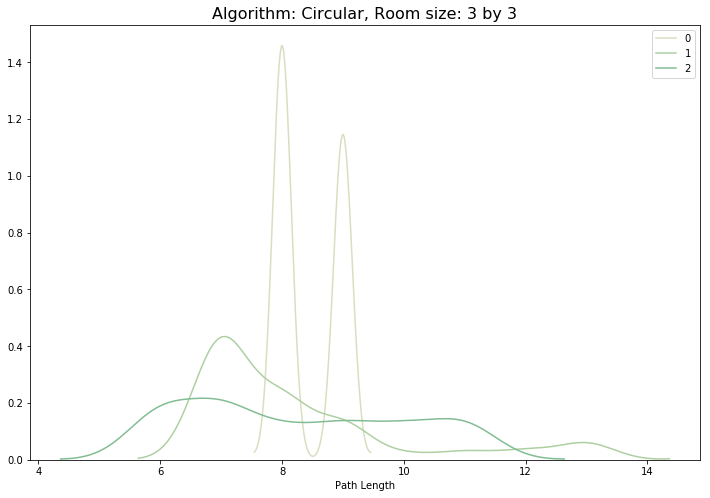

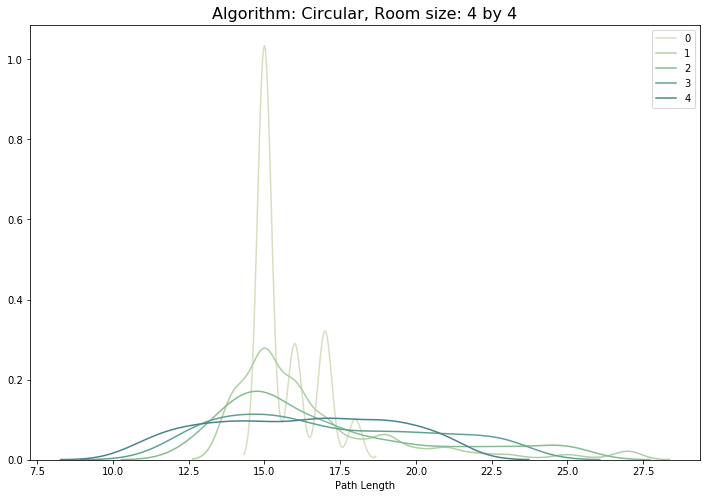

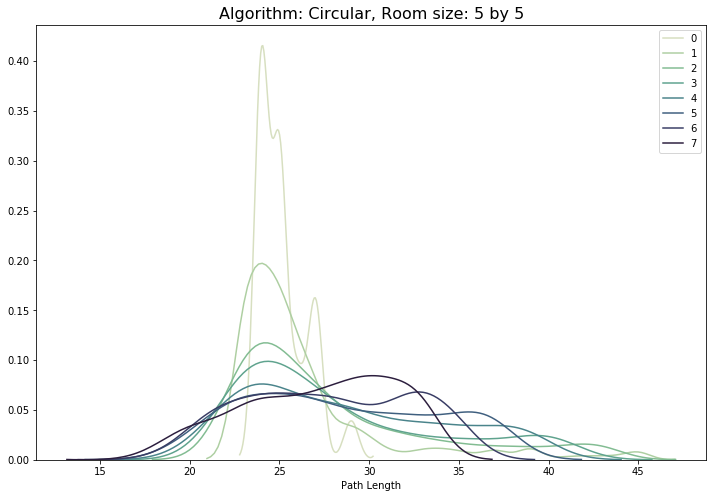

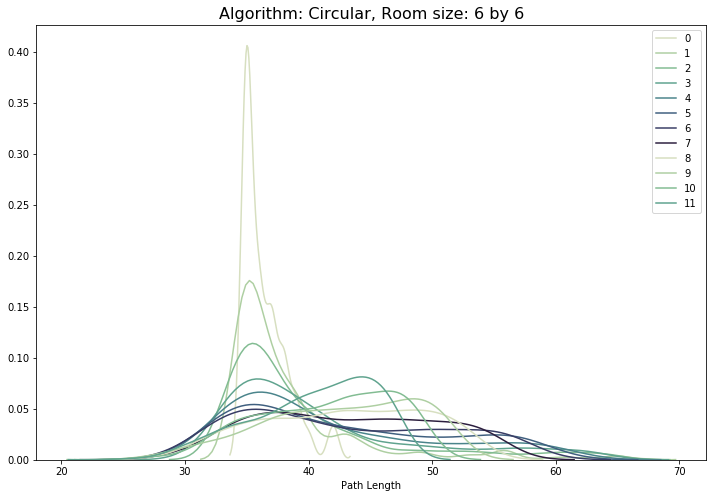

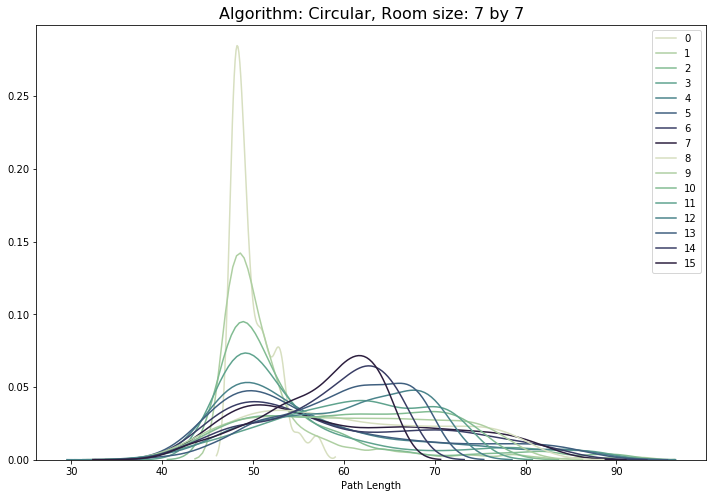

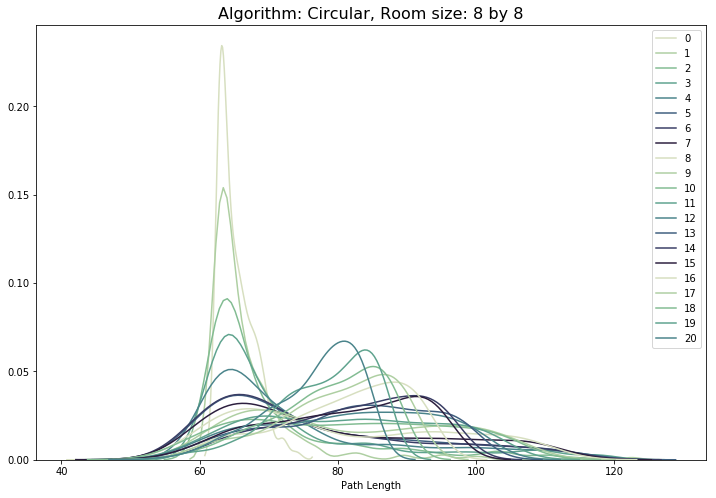

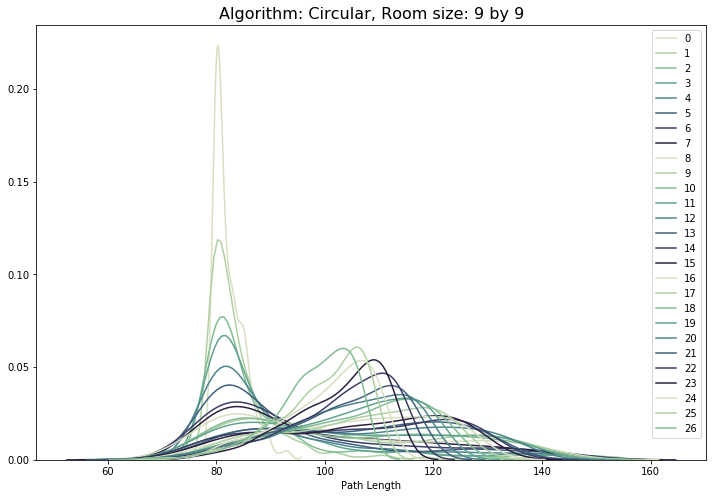

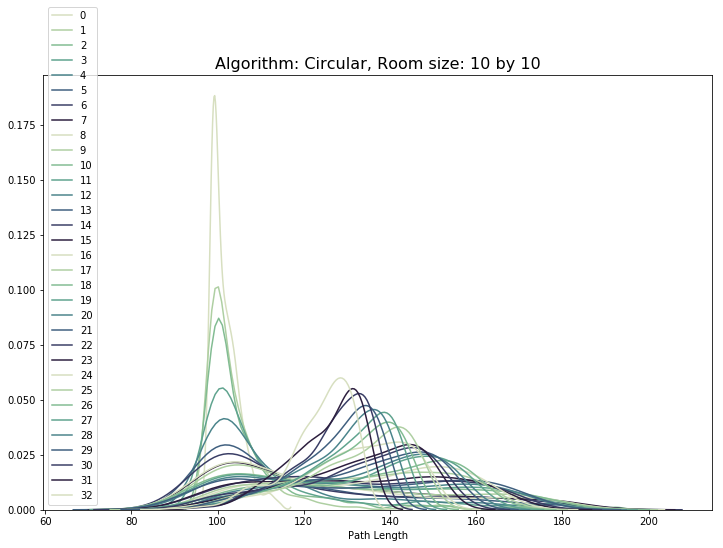

In [808]:
sns.set_palette(sns.cubehelix_palette(8, start=.5, rot=-.75))

for room_length in range(min_room + 2, max_room + 1):
#     for obstacles in range(room_length):
    plt.figure(figsize = (12, 8))
    for obstacles in range(floor((room_length**2)/3)):
        
        A = np.array(times_circular)[:,0] == room_length
        B = np.array(times_circular)[:,1] == obstacles
        
#         plt.hist(np.array(times_circular)[:, 2][A & B], label = obstacles)
        sns.kdeplot(np.array(times_circular)[:, 2][A & B], label = obstacles)
    plt.title(f'Algorithm: Circular, Room size: {room_length} by {room_length}', fontsize = 16)
    plt.xlabel("Path Length")
    plt.legend()
    plt.savefig(f"circular_{room_length}.png", bbox_inches='tight')
    plt.show()

## Kurtosis and Skew

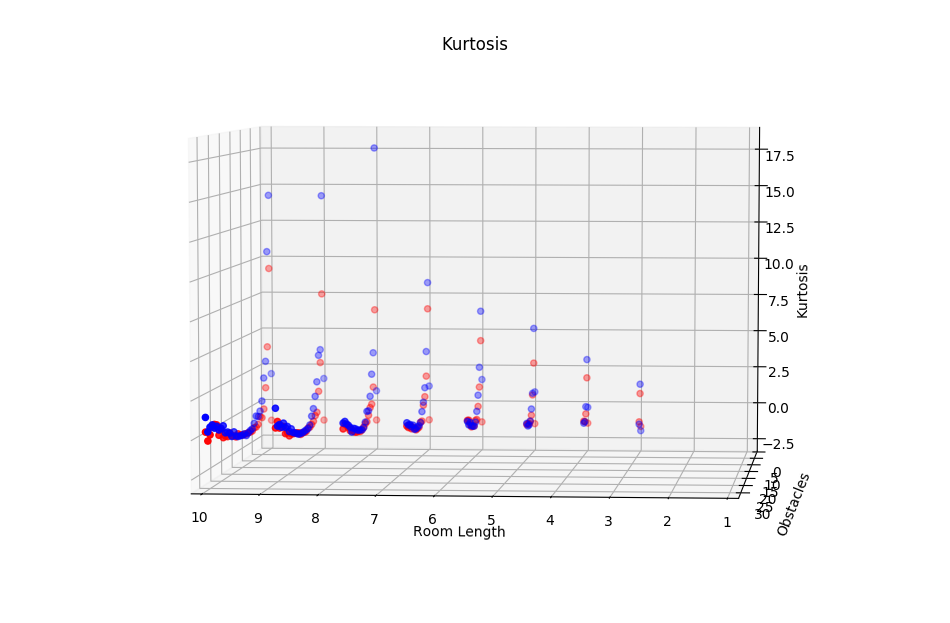

In [888]:
kurtosis_dfs, kurtosis_circular = [], []

for room_length in range(min_room + 2, max_room + 1):
    for obstacles in range(floor((room_length**2)/3)):
        
        ## boolean mask
        A, B = (np.array(times_dfs)[:,0] == room_length), (np.array(times_dfs)[:,1] == obstacles)
        
            kurtosis_dfs.append([room_length, obstacles, sp.kurtosis(np.array(times_dfs)[:, 2][A & B], fisher = False)])
        kurtosis_circular.append([room_length, obstacles, sp.kurtosis(np.array(times_circular)[:, 2][A & B], fisher = False)])
        
        
fig = plt.figure(figsize = (12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=5, azim=95)
ax.set_xlabel('Room Length', linespacing=3.4)
ax.set_ylabel('Obstacles', linespacing=3.4)
ax.set_zlabel('Kurtosis', linespacing=3.4)
ax.set_xlim3d(min_room, max_room)
ax.set_ylim3d(0, floor((room_length**2)/3)) # obstacles max room_length

ax.scatter(np.array(kurtosis_dfs)[:,0], np.array(kurtosis_dfs)[:,1], np.array(kurtosis_dfs)[:,2], c = "red")
ax.scatter(np.array(kurtosis_circular)[:,0], np.array(kurtosis_circular)[:,1], np.array(kurtosis_circular)[:,2], c = "blue")

plt.title('Kurtosis')
# plt.savefig(f"Kurtosis.png", bbox_inches='tight')
plt.show()

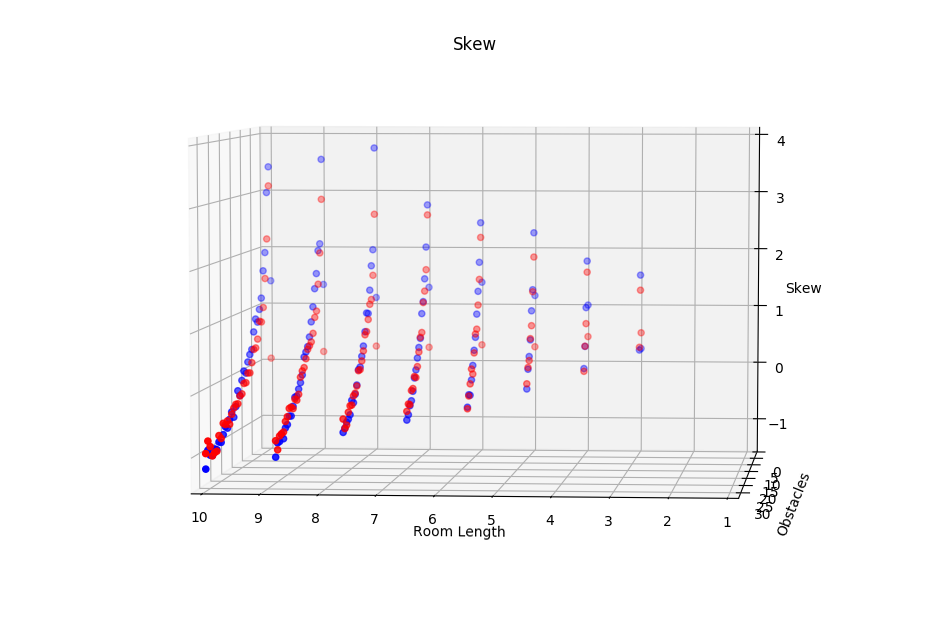

In [881]:
skew_dfs, skew_circular = [], []

for room_length in range(min_room + 2, max_room + 1):
    for obstacles in range(floor((room_length**2)/3)):
        
        ## boolean mask
        A, B = (np.array(times_dfs)[:,0] == room_length), (np.array(times_dfs)[:,1] == obstacles)
        
        skew_dfs.append([room_length, obstacles, sp.skew(np.array(times_dfs)[:, 2][A & B])])
        skew_circular.append([room_length, obstacles, sp.skew(np.array(times_circular)[:, 2][A & B])])
        
        
fig = plt.figure(figsize = (12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=5, azim=95)
ax.set_xlabel('Room Length', linespacing=3.4)
ax.set_ylabel('Obstacles', linespacing=3.4)
ax.set_zlabel('Skew', linespacing=3.4)
ax.set_xlim3d(min_room, max_room)
ax.set_ylim3d(0, floor((room_length**2)/3)) # obstacles max room_length

ax.scatter(np.array(skew_dfs)[:,0], np.array(skew_dfs)[:,1], np.array(skew_dfs)[:,2], c = "red")
ax.scatter(np.array(skew_circular)[:,0], np.array(skew_circular)[:,1], np.array(skew_circular)[:,2], c = "blue")

plt.title('Skew')
plt.savefig(f"Skew.png", bbox_inches='tight')
plt.show()



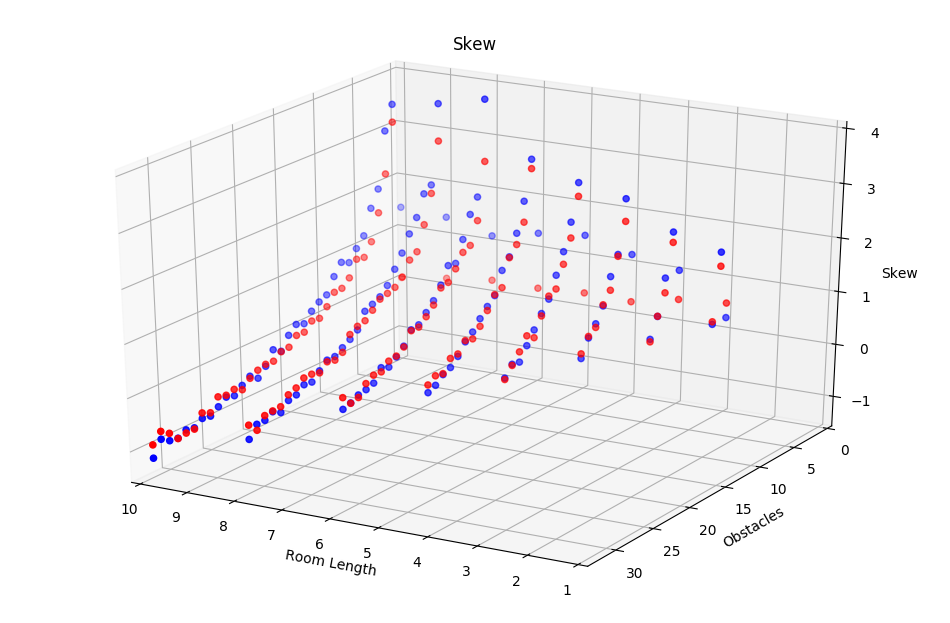

In [883]:
fig = plt.figure(figsize = (12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=25, azim=120)
ax.set_xlabel('Room Length', linespacing=3.4)
ax.set_ylabel('Obstacles', linespacing=3.4)
ax.set_zlabel('Skew', linespacing=3.4)
ax.set_xlim3d(min_room, max_room)
ax.set_ylim3d(0, floor((room_length**2)/3)) # obstacles max room_length

ax.scatter(np.array(skew_dfs)[:,0], np.array(skew_dfs)[:,1], np.array(skew_dfs)[:,2], c = "red")
ax.scatter(np.array(skew_circular)[:,0], np.array(skew_circular)[:,1], np.array(skew_circular)[:,2], c = "blue")

plt.title('Skew')
plt.savefig(f"Skew.png", bbox_inches='tight')
plt.show()

In [ ]:
aa